We will also do a base model for comparison for the Bayesian latent AR process model. This model will be a regular sequential model, like an LSTM. For this model, we will use the extracted features and the corresponding densities. Something ot consider here is, we do get the extracted features from the previous exercise, however, did we also keep track of the corresponding densities? If we do not have the densities, we need to first get the densities, have them in a sequence, and then think about how best to fit the model. The base model may also have a encoder-decoder model? Or do we just use a dense neural network? 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from scipy import ndimage
import xml
import xml.etree.ElementTree as ET
import cv2
import warnings
from skimage.transform import resize

2025-06-20 12:14:28.737977: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 12:14:28.772632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-20 12:14:28.772658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-20 12:14:28.773444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-20 12:14:28.780195: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# First preprocess the data for the base model / or maybe even the Bayesian latent AR process model.

In [4]:
# First do it for a single block, and then repeat it for the rest of the blocks

In [5]:
# horizontal image dates?
horizontal_image_list = ['2020_08_03', '2020_08_04', '2020_08_06', '2020_08_07', '2020_08_11', '2020_08_12', '2020_08_14', '2020_08_15', '2020_08_17', '2020_08_18', '2020_08_19', '2020_08_21', '2020_08_25', '2020_08_26', '2020_08_27', '2020_08_28', '2020_08_31', '2020_09_02', '2020_09_07', '2020_09_16']

In [6]:
def get_horizontal_images(file_path):
    # get all contents at the file path
    all_files = os.listdir(file_path)
    # get only the image files as we do not need the xml files for the seq2seq model
    only_images = [file for file in all_files if file.split(".")[-1] == 'jpeg']
    # from all the images only choose the horizontal ones
    horizontal_images = [file for file in only_images if file.split('.')[0][-10:] in horizontal_image_list]
    # sort the list
    horizontal_images.sort()
    # return the image list
    return horizontal_images

Try this first for block 0101

In [7]:
# for block 0101
blk_0101_data_path = '../../Spring_2024/S_lab_TasselNet/Block_1_TN/Block_1_images_and_xml'

In [8]:
# What all is there? - both image and xml files

In [9]:
# get the horizontal images?
horizontal_images = get_horizontal_images(blk_0101_data_path)

In [10]:
horizontal_images

['Block0101_2020_08_03.jpeg',
 'Block0101_2020_08_04.jpeg',
 'Block0101_2020_08_06.jpeg',
 'Block0101_2020_08_07.jpeg',
 'Block0101_2020_08_11.jpeg',
 'Block0101_2020_08_12.jpeg',
 'Block0101_2020_08_14.jpeg',
 'Block0101_2020_08_15.jpeg',
 'Block0101_2020_08_17.jpeg',
 'Block0101_2020_08_18.jpeg',
 'Block0101_2020_08_19.jpeg',
 'Block0101_2020_08_21.jpeg',
 'Block0101_2020_08_25.jpeg',
 'Block0101_2020_08_26.jpeg',
 'Block0101_2020_08_27.jpeg',
 'Block0101_2020_08_28.jpeg',
 'Block0101_2020_08_31.jpeg',
 'Block0101_2020_09_02.jpeg',
 'Block0101_2020_09_07.jpeg',
 'Block0101_2020_09_16.jpeg']

In [11]:
# create a list of xml files for these images using the list created
horizontal_xml_files = [i.split('.')[0] + '.xml' for i in horizontal_images]

In [12]:
horizontal_xml_files

['Block0101_2020_08_03.xml',
 'Block0101_2020_08_04.xml',
 'Block0101_2020_08_06.xml',
 'Block0101_2020_08_07.xml',
 'Block0101_2020_08_11.xml',
 'Block0101_2020_08_12.xml',
 'Block0101_2020_08_14.xml',
 'Block0101_2020_08_15.xml',
 'Block0101_2020_08_17.xml',
 'Block0101_2020_08_18.xml',
 'Block0101_2020_08_19.xml',
 'Block0101_2020_08_21.xml',
 'Block0101_2020_08_25.xml',
 'Block0101_2020_08_26.xml',
 'Block0101_2020_08_27.xml',
 'Block0101_2020_08_28.xml',
 'Block0101_2020_08_31.xml',
 'Block0101_2020_09_02.xml',
 'Block0101_2020_09_07.xml',
 'Block0101_2020_09_16.xml']

In [13]:
# now need to create the density maps and then the corresponding stacks for the densities

In [14]:
# For this base model at least, we only need the density maps for the last 7 images. So for the moment, we will only work with those? 

In [15]:
# last 7 image files and xml files
im_files_for_densities = horizontal_images[-7:]
im_files_for_densities.sort()
xml_files_for_densities = horizontal_xml_files[-7:]
xml_files_for_densities.sort()

In [16]:
# im_files_for_densities, xml_files_for_densities

In [17]:
# just the file names 
all_file_names = [file.split('.')[0] for file in im_files_for_densities]

In [18]:
# all_file_names

In [19]:
# for vertically annotated images
def get_density_maps_horizontal(file_name, image_path, xml_path, save_density_path):
    xml_file = file_name + '.xml'
    xml_file_path = os.path.join(xml_path, xml_file)

    # Get coords from the xml file
    # parse the xml file
    parsed_file = ET.parse(xml_file_path)
    # get the roots
    root = parsed_file.getroot()
    # get the roots here
    coords = []
    for child in root:
        for i in child:
            for j in i:
                coords.append(int(j.text))
    
    # chunk the points into sets of 4 - these are the coordinates of the bounding boxes
    points_tupples = []
    for i in range(0, len(coords), 4):
        points_tupples.append(coords[i:i + 4])

    # make a dataframe with these points
    coords_df = pd.DataFrame(points_tupples, columns = ["bleft_x", "bleft_y", "tright_x", "tright_y"])

    # compute the number of tassels in each image
    no_of_tassels = len(points_tupples)

    # compute the mid coordinates
    coords_df["mid_x"] = (round(0.5*(coords_df["bleft_x"] + coords_df["tright_x"]))).astype(int)
    coords_df["mid_y"] = (round(0.5*(coords_df["bleft_y"] + coords_df["tright_y"]))).astype(int)

    # extract the mid cordinates
    mid_coords = coords_df[["mid_x", "mid_y"]]
    # cap the coords at the max height and width values
    mid_coords.loc[mid_coords['mid_x'] > 1024, 'mid_x'] = 1023
    mid_coords.loc[mid_coords['mid_y'] > 768, 'mid_y'] = 767
    warnings.filterwarnings("ignore")

    # plot the bounding boxes on images
    # get image name and path
    image_name = file_name + '.jpeg'
    imge_file_path = os.path.join(image_path, image_name)
    # read the image
    read_image = plt.imread(imge_file_path)
    read_image = ndimage.rotate(read_image, 0)

    # check the shape of the read image
    read_image_shape = read_image.shape
    #  plot the bounding boxes on the image
    for points in points_tupples:
        annotated_image = cv2.rectangle(read_image, (points[0],points[1]), (points[2],points[3]), color = (255,0,0), thickness = 2)
    # plt.figure(figsize = (12,18))
    plt.imshow(annotated_image)
    plt.show()

    # plot the mid points on the image
    coords_list = mid_coords.values.tolist()
    # read the image again
    read_image_again = plt.imread(imge_file_path)
    read_image_again = ndimage.rotate(read_image_again, 0)
    # draw the circles on image
    for i in coords_list:
        image_with_mids = cv2.circle(read_image_again, i, radius=5, color=(255, 0, 0), thickness=-1)
    # look at the annotated image
    # plt.figure(figsize = (12,18))
    plt.imshow(image_with_mids)
    plt.show()

    # also try creating the density map here
    # first create the empty maps
    np_image = np.zeros((read_image_shape[0], read_image_shape[1]))
    # get the dot maps
    for point in coords_list:
        np_image[point[1], point[0]] = 1
    # plot the image
    # plt.figure(figsize = (12,18))
    plt.imshow(np_image, cmap = "Greys")
    plt.show()

    # now define the kernel and run the convolution
    one_d_kerenel = cv2.getGaussianKernel(50,5)
    two_d_kernel = np.multiply(one_d_kerenel.T, one_d_kerenel)

    # Shape of the 2D kernel
    twoD_shape = two_d_kernel.shape
        
    # do the convolution
    convolution = ndimage.convolve(np_image, two_d_kernel)
        
    # plot the density map
    # plt.figure(figsize = (12,18))
    plt.imshow(convolution, cmap = "Greys")
    plt.show()
        
    # get the sums of the images
    img_sum = np.sum(convolution)

    # save the density map
    np.save(save_density_path + '/' + file_name + '_density_map.npy', convolution)

    return(file_name, read_image_shape, no_of_tassels, img_sum, convolution)

In [20]:
# where to sve the convolved density maps?
save_densities_here = 'all_density_maps/block_0101'

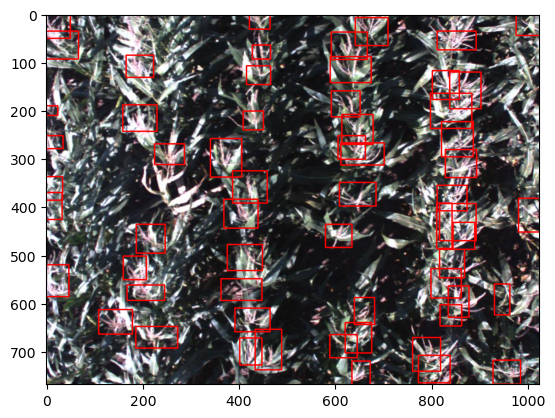

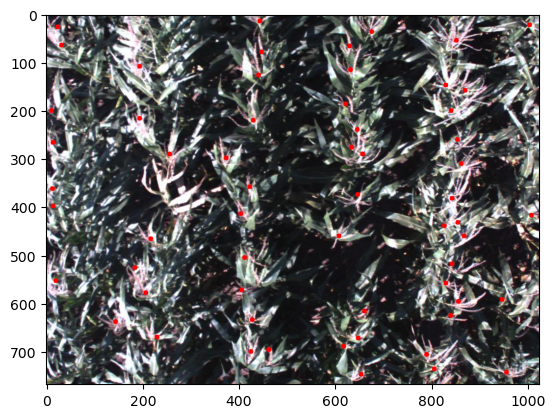

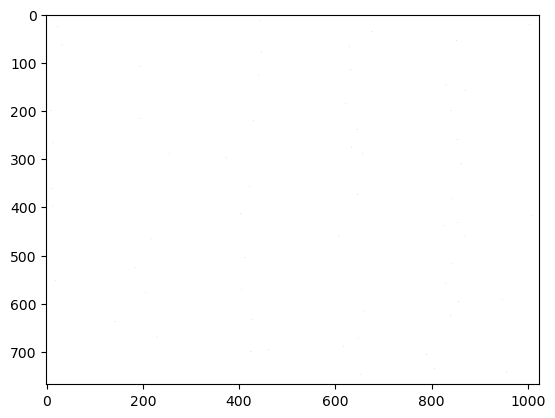

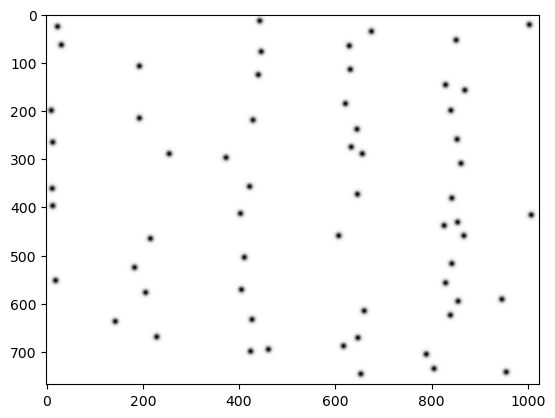

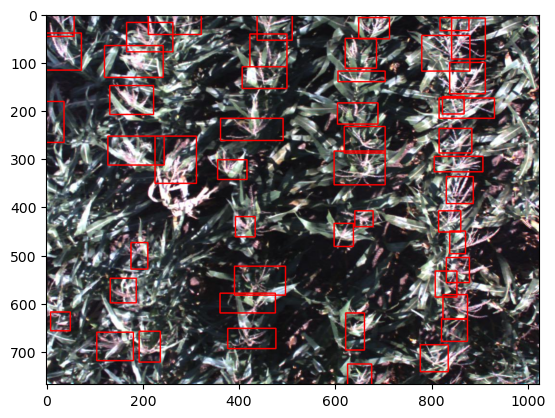

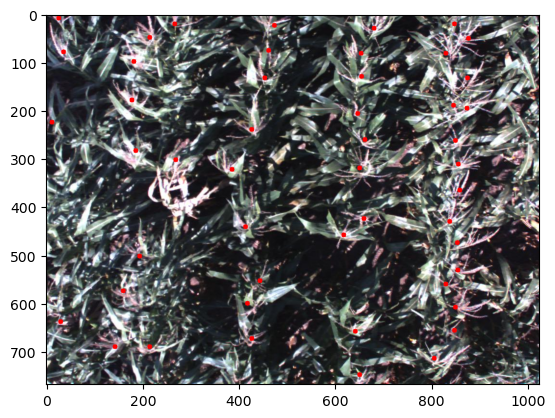

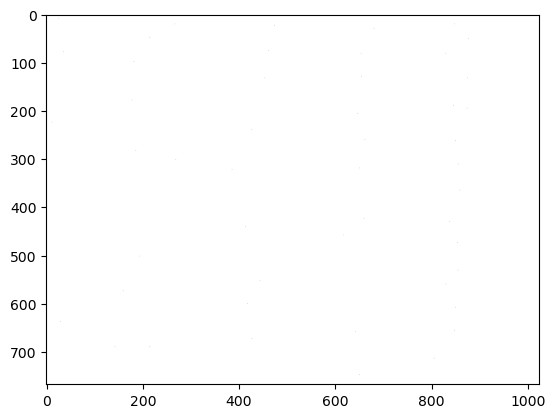

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_h = []
shapes_all_h = []
tasselCounts_all_h = []
tasselDensities_all_h = []
dense_maps_all_h = []
for file_h in all_file_names:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0101_data_path, blk_0101_data_path, save_densities_here)
    names_all_h.append(name_h)
    shapes_all_h.append(shape_h)
    tasselCounts_all_h.append(tassels_h)
    tasselDensities_all_h.append(tassel_dense_h)
    dense_maps_all_h.append(dense_map_h)
    

In [ ]:
# So what happens now? We have the convolved maps, we need to create subwindows, which are not over lapping

In [ ]:
# location of the density maps
save_densities_here 

In [ ]:
# Use the function below
def create_densities_for_subwindows(file_name, numpy_folder, stride = 30, kernel_size = 30):
    count_file = file_name + '_density_map.npy'
    # # load the count numpy files
    loaded_count_file = np.load(numpy_folder + '/' + count_file)
        
    # create the counts for the subwindows as follows
    img_height = loaded_count_file.shape[0]
    img_width = loaded_count_file.shape[1]
    
    density_sums = []
    for i in  range(0, img_height, stride):
        for j in range(0, img_width, stride):
            # sub_window = loaded_im_file[i: i + kernel_size, j : j + kernel_size,:]
            density = loaded_count_file[i: i + kernel_size, j : j + kernel_size]
            dense_sum = np.sum(density)
            density_sums.append(dense_sum)

    print("sum of the convolved map: ", np.sum(density_sums))
    return density_sums

In [ ]:
# test this for a single density map
test_0 = create_densities_for_subwindows(all_file_names[0],save_densities_here )

In [ ]:
len(test_0)

In [ ]:
# the values seem prety decent too - we still might need a sanity check, what about the true counts all?

In [ ]:
# below list has the counts for the 7 test images in order
tasselCounts_all_h

In [ ]:
# since we do not do overlapping sub-windows, the sum of the densities for the test_0 list should match tasselCounts_all_h[0] value which is 60

In [ ]:
np.sum(test_0)

In [ ]:
# the values do match, we should be okay

In [ ]:
# Okay, now we should do this for all the images in the test set for block 0101? Do this in a loop

In [ ]:
%%time

all_density_lists = []
for file_name in all_file_names:
    density_values = create_densities_for_subwindows(file_name, save_densities_here, stride = 30, kernel_size = 30)
    all_density_lists.append(density_values)

In [ ]:
len(all_density_lists[0])

In [ ]:
# need to stack this list
all_density_stack = np.stack(all_density_lists, axis = 1)

In [ ]:
all_density_stack.shape

In [ ]:
# need some sanity checks to make sure the stacking is right

# what if we get the sums across the rows? they should match the density list we have above

In [ ]:
np.mean(np.round(np.sum(all_density_stack, axis = 0)) == tasselCounts_all_h)

In [ ]:
# The stacking seems correct

In [ ]:
# save the stack

In [ ]:
np.save("stacked_densities/stacked_densities_block_0101.npy", all_density_stack)

Repeat this process for all the other blocks

Block 0102

In [ ]:
# Path to data
blk_0102_data_path = '../../Spring_2024/S_lab_TasselNet/Block_2_TN/Block_2_images_and_xml'

In [ ]:
# May be do some function that gets the images, corresponding xml files and the name only files

In [ ]:
def jpeg_xml_name_files(path_to_images_and_xmls):
    horizontal_images_all = get_horizontal_images(path_to_images_and_xmls)
    horizontal_xmls_all = [i.split('.')[0] + '.xml' for i in horizontal_images_all]
    last_7_images = horizontal_images_all[-7:]
    last_7_images.sort()
    last_7_xmls = horizontal_xmls_all[-7:]
    last_7_xmls.sort()
    horizontal_name_files = [file.split(".")[0] for file in last_7_images]

    return last_7_images, last_7_xmls, horizontal_name_files

In [ ]:
images_0102, xml_0102, file_names_0102 = jpeg_xml_name_files(blk_0102_data_path)

In [ ]:
images_0102, xml_0102, file_names_0102

In [ ]:
# save densities here
save_densities_0102 = 'all_density_maps/block_0102'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0102 = []
shapes_all_0102 = []
tasselCounts_all_0102 = []
tasselDensities_all_0102 = []
dense_maps_all_0102 = []
for file_h in file_names_0102:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0102_data_path, blk_0102_data_path, save_densities_0102)
    names_all_0102.append(name_h)
    shapes_all_0102.append(shape_h)
    tasselCounts_all_0102.append(tassels_h)
    tasselDensities_all_0102.append(tassel_dense_h)
    dense_maps_all_0102.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0102 = []
for file_name in file_names_0102:
    density_values = create_densities_for_subwindows(file_name, save_densities_0102, stride = 30, kernel_size = 30)
    all_density_lists_0102.append(density_values)

In [ ]:
tasselCounts_all_0102

In [ ]:
# need to stack this list
density_stack_0102 = np.stack(all_density_lists_0102, axis = 1)

In [ ]:
density_stack_0102.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0102.npy", density_stack_0102)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0102, axis = 0)) == tasselCounts_all_0102)

Block 0103

In [ ]:
# Path to data
blk_0103_data_path = '../../Spring_2024/S_lab_TasselNet/Block_3_TN/Block_3_images_and_xml'

In [ ]:
images_0103, xml_0103, file_names_0103 = jpeg_xml_name_files(blk_0103_data_path)

In [ ]:
images_0103, xml_0103, file_names_0103

In [ ]:
# save densities here
save_densities_0103 = 'all_density_maps/block_0103'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0103 = []
shapes_all_0103 = []
tasselCounts_all_0103 = []
tasselDensities_all_0103 = []
dense_maps_all_0103 = []
for file_h in file_names_0103:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0103_data_path, blk_0103_data_path, save_densities_0103)
    names_all_0103.append(name_h)
    shapes_all_0103.append(shape_h)
    tasselCounts_all_0103.append(tassels_h)
    tasselDensities_all_0103.append(tassel_dense_h)
    dense_maps_all_0103.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0103 = []
for file_name in file_names_0103:
    density_values = create_densities_for_subwindows(file_name, save_densities_0103, stride = 30, kernel_size = 30)
    all_density_lists_0103.append(density_values)

In [ ]:
tasselCounts_all_0103

In [ ]:
# need to stack this list
density_stack_0103 = np.stack(all_density_lists_0103, axis = 1)

In [ ]:
density_stack_0103.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0103.npy", density_stack_0103)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0103, axis = 0)) == tasselCounts_all_0103)

Block 0104

In [ ]:
# Path to data
blk_0104_data_path = '../../Spring_2024/S_lab_TasselNet/Block_4_TN/Block_4_images_and_xml'

In [ ]:
images_0104, xml_0104, file_names_0104 = jpeg_xml_name_files(blk_0104_data_path)

In [ ]:
images_0104, xml_0104, file_names_0104

In [ ]:
# save densities here
save_densities_0104 = 'all_density_maps/block_0104'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0104 = []
shapes_all_0104 = []
tasselCounts_all_0104 = []
tasselDensities_all_0104 = []
dense_maps_all_0104 = []
for file_h in file_names_0104:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0104_data_path, blk_0104_data_path, save_densities_0104)
    names_all_0104.append(name_h)
    shapes_all_0104.append(shape_h)
    tasselCounts_all_0104.append(tassels_h)
    tasselDensities_all_0104.append(tassel_dense_h)
    dense_maps_all_0104.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0104 = []
for file_name in file_names_0104:
    density_values = create_densities_for_subwindows(file_name, save_densities_0104, stride = 30, kernel_size = 30)
    all_density_lists_0104.append(density_values)

In [ ]:
tasselCounts_all_0104

In [ ]:
# need to stack this list
density_stack_0104 = np.stack(all_density_lists_0104, axis = 1)

In [ ]:
density_stack_0104.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0104.npy", density_stack_0104)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0104, axis = 0)) == tasselCounts_all_0104)

Block 0105

In [ ]:
# Path to data
blk_0105_data_path = '../../Spring_2024/S_lab_TasselNet/Block_5_TN/Block_5_images_and_xml'

In [ ]:
images_0105, xml_0105, file_names_0105 = jpeg_xml_name_files(blk_0105_data_path)

In [ ]:
images_0105, xml_0105, file_names_0105

In [ ]:
# save densities here
save_densities_0105 = 'all_density_maps/block_0105'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0105 = []
shapes_all_0105 = []
tasselCounts_all_0105 = []
tasselDensities_all_0105 = []
dense_maps_all_0105 = []
for file_h in file_names_0105:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0105_data_path, blk_0105_data_path, save_densities_0105)
    names_all_0105.append(name_h)
    shapes_all_0105.append(shape_h)
    tasselCounts_all_0105.append(tassels_h)
    tasselDensities_all_0105.append(tassel_dense_h)
    dense_maps_all_0105.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0105 = []
for file_name in file_names_0105:
    density_values = create_densities_for_subwindows(file_name, save_densities_0105, stride = 30, kernel_size = 30)
    all_density_lists_0105.append(density_values)

In [ ]:
tasselCounts_all_0105

In [ ]:
# need to stack this list
density_stack_0105 = np.stack(all_density_lists_0105, axis = 1)

In [ ]:
density_stack_0105.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0105.npy", density_stack_0105)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0105, axis = 0)) == tasselCounts_all_0105)

Block 0106

In [ ]:
# Path to data
blk_0106_data_path = '../../Spring_2024/S_lab_TasselNet/Block_6_TN/Block_6_images_and_xml'

In [ ]:
images_0106, xml_0106, file_names_0106 = jpeg_xml_name_files(blk_0106_data_path)

In [ ]:
images_0106, xml_0106, file_names_0106

In [ ]:
# save densities here
save_densities_0106 = 'all_density_maps/block_0106'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0106 = []
shapes_all_0106 = []
tasselCounts_all_0106 = []
tasselDensities_all_0106 = []
dense_maps_all_0106 = []
for file_h in file_names_0106:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0106_data_path, blk_0106_data_path, save_densities_0106)
    names_all_0106.append(name_h)
    shapes_all_0106.append(shape_h)
    tasselCounts_all_0106.append(tassels_h)
    tasselDensities_all_0106.append(tassel_dense_h)
    dense_maps_all_0106.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0106 = []
for file_name in file_names_0106:
    density_values = create_densities_for_subwindows(file_name, save_densities_0106, stride = 30, kernel_size = 30)
    all_density_lists_0106.append(density_values)

In [ ]:
tasselCounts_all_0106

In [ ]:
# need to stack this list
density_stack_0106 = np.stack(all_density_lists_0106, axis = 1)

In [ ]:
density_stack_0106.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0106.npy", density_stack_0106)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0106, axis = 0)) == tasselCounts_all_0106)

Block 0201

In [ ]:
# Path to data
blk_0201_data_path = '../../Spring_2024/S_lab_TasselNet/Block_7_TN/Block_7_images_and_xml'

In [ ]:
images_0201, xml_0201, file_names_0201 = jpeg_xml_name_files(blk_0201_data_path)

In [ ]:
images_0201, xml_0201, file_names_0201

In [ ]:
# save densities here
save_densities_0201 = 'all_density_maps/block_0201'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0201 = []
shapes_all_0201 = []
tasselCounts_all_0201 = []
tasselDensities_all_0201 = []
dense_maps_all_0201 = []
for file_h in file_names_0201:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0201_data_path, blk_0201_data_path, save_densities_0201)
    names_all_0201.append(name_h)
    shapes_all_0201.append(shape_h)
    tasselCounts_all_0201.append(tassels_h)
    tasselDensities_all_0201.append(tassel_dense_h)
    dense_maps_all_0201.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0201 = []
for file_name in file_names_0201:
    density_values = create_densities_for_subwindows(file_name, save_densities_0201, stride = 30, kernel_size = 30)
    all_density_lists_0201.append(density_values)

In [ ]:
tasselCounts_all_0201

In [ ]:
# need to stack this list
density_stack_0201 = np.stack(all_density_lists_0201, axis = 1)

In [ ]:
density_stack_0201.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0201.npy", density_stack_0201)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0201, axis = 0)) == tasselCounts_all_0201)

Block 0202

In [ ]:
# Path to data
blk_0202_data_path = '../../Spring_2024/S_lab_TasselNet/Block_8_TN/Block_8_images_and_xml'

In [ ]:
images_0202, xml_0202, file_names_0202 = jpeg_xml_name_files(blk_0202_data_path)

In [ ]:
images_0202, xml_0202, file_names_0202

In [ ]:
# save densities here
save_densities_0202 = 'all_density_maps/block_0202'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0202 = []
shapes_all_0202 = []
tasselCounts_all_0202 = []
tasselDensities_all_0202 = []
dense_maps_all_0202 = []
for file_h in file_names_0202:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0202_data_path, blk_0202_data_path, save_densities_0202)
    names_all_0202.append(name_h)
    shapes_all_0202.append(shape_h)
    tasselCounts_all_0202.append(tassels_h)
    tasselDensities_all_0202.append(tassel_dense_h)
    dense_maps_all_0202.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0202 = []
for file_name in file_names_0202:
    density_values = create_densities_for_subwindows(file_name, save_densities_0202, stride = 30, kernel_size = 30)
    all_density_lists_0202.append(density_values)

In [ ]:
tasselCounts_all_0202

In [ ]:
# need to stack this list
density_stack_0202 = np.stack(all_density_lists_0202, axis = 1)

In [ ]:
density_stack_0202.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0202.npy", density_stack_0202)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0202, axis = 0)) == tasselCounts_all_0202)

Block 0203

In [ ]:
# Path to data
blk_0203_data_path = '../../Spring_2024/S_lab_TasselNet/Block_9_TN/Block_9_images_and_xml'

In [ ]:
images_0203, xml_0203, file_names_0203 = jpeg_xml_name_files(blk_0203_data_path)

In [ ]:
images_0203, xml_0203, file_names_0203

In [ ]:
# save densities here
save_densities_0203 = 'all_density_maps/block_0203'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0203 = []
shapes_all_0203 = []
tasselCounts_all_0203 = []
tasselDensities_all_0203 = []
dense_maps_all_0203 = []
for file_h in file_names_0203:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0203_data_path, blk_0203_data_path, save_densities_0203)
    names_all_0203.append(name_h)
    shapes_all_0203.append(shape_h)
    tasselCounts_all_0203.append(tassels_h)
    tasselDensities_all_0203.append(tassel_dense_h)
    dense_maps_all_0203.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0203 = []
for file_name in file_names_0203:
    density_values = create_densities_for_subwindows(file_name, save_densities_0203, stride = 30, kernel_size = 30)
    all_density_lists_0203.append(density_values)

In [ ]:
tasselCounts_all_0203

In [ ]:
# need to stack this list
density_stack_0203 = np.stack(all_density_lists_0203, axis = 1)

In [ ]:
density_stack_0203.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0203.npy", density_stack_0203)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0203, axis = 0)) == tasselCounts_all_0203)

Block 0204

In [ ]:
# Path to data
blk_0204_data_path = '../../Spring_2024/S_lab_TasselNet/Block_10_TN/Block_10_images_and_xml'

In [ ]:
images_0204, xml_0204, file_names_0204 = jpeg_xml_name_files(blk_0204_data_path)

In [ ]:
images_0204, xml_0204, file_names_0204

In [ ]:
# save densities here
save_densities_0204 = 'all_density_maps/block_0204'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0204 = []
shapes_all_0204 = []
tasselCounts_all_0204 = []
tasselDensities_all_0204 = []
dense_maps_all_0204 = []
for file_h in file_names_0204:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0204_data_path, blk_0204_data_path, save_densities_0204)
    names_all_0204.append(name_h)
    shapes_all_0204.append(shape_h)
    tasselCounts_all_0204.append(tassels_h)
    tasselDensities_all_0204.append(tassel_dense_h)
    dense_maps_all_0204.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0204 = []
for file_name in file_names_0204:
    density_values = create_densities_for_subwindows(file_name, save_densities_0204, stride = 30, kernel_size = 30)
    all_density_lists_0204.append(density_values)

In [ ]:
tasselCounts_all_0204

In [ ]:
# need to stack this list
density_stack_0204 = np.stack(all_density_lists_0204, axis = 1)

In [ ]:
density_stack_0204.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0204.npy", density_stack_0204)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0204, axis = 0)) == tasselCounts_all_0204)

Block 0205

In [ ]:
# Path to data
blk_0205_data_path = '../../Spring_2024/S_lab_TasselNet/Block_11_TN/Block_11_images_and_xml'

In [ ]:
images_0205, xml_0205, file_names_0205 = jpeg_xml_name_files(blk_0205_data_path)

In [ ]:
images_0205, xml_0205, file_names_0205

In [ ]:
# save densities here
save_densities_0205 = 'all_density_maps/block_0205'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0205 = []
shapes_all_0205 = []
tasselCounts_all_0205 = []
tasselDensities_all_0205 = []
dense_maps_all_0205 = []
for file_h in file_names_0205:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0205_data_path, blk_0205_data_path, save_densities_0205)
    names_all_0205.append(name_h)
    shapes_all_0205.append(shape_h)
    tasselCounts_all_0205.append(tassels_h)
    tasselDensities_all_0205.append(tassel_dense_h)
    dense_maps_all_0205.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0205 = []
for file_name in file_names_0205:
    density_values = create_densities_for_subwindows(file_name, save_densities_0205, stride = 30, kernel_size = 30)
    all_density_lists_0205.append(density_values)

In [ ]:
tasselCounts_all_0205

In [ ]:
# need to stack this list
density_stack_0205 = np.stack(all_density_lists_0205, axis = 1)

In [ ]:
density_stack_0205.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0205.npy", density_stack_0205)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0205, axis = 0)) == tasselCounts_all_0205)

Block 0206

In [ ]:
# Path to data
blk_0206_data_path = '../../Spring_2024/S_lab_TasselNet/Block_12_TN/Block_12_images_and_xml'

In [ ]:
images_0206, xml_0206, file_names_0206 = jpeg_xml_name_files(blk_0206_data_path)

In [ ]:
images_0206, xml_0206, file_names_0206

In [ ]:
# save densities here
save_densities_0206 = 'all_density_maps/block_0206'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0206 = []
shapes_all_0206 = []
tasselCounts_all_0206 = []
tasselDensities_all_0206 = []
dense_maps_all_0206 = []
for file_h in file_names_0206:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0206_data_path, blk_0206_data_path, save_densities_0206)
    names_all_0206.append(name_h)
    shapes_all_0206.append(shape_h)
    tasselCounts_all_0206.append(tassels_h)
    tasselDensities_all_0206.append(tassel_dense_h)
    dense_maps_all_0206.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0206 = []
for file_name in file_names_0206:
    density_values = create_densities_for_subwindows(file_name, save_densities_0206, stride = 30, kernel_size = 30)
    all_density_lists_0206.append(density_values)

In [ ]:
tasselCounts_all_0206

In [ ]:
# need to stack this list
density_stack_0206 = np.stack(all_density_lists_0206, axis = 1)

In [ ]:
density_stack_0206.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0206.npy", density_stack_0206)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0206, axis = 0)) == tasselCounts_all_0206)

Block 0301

In [ ]:
# Path to data
blk_0301_data_path = '../../Spring_2024/S_lab_TasselNet/Block_13_TN/Block_13_images_and_xml'

In [ ]:
images_0301, xml_0301, file_names_0301 = jpeg_xml_name_files(blk_0301_data_path)

In [ ]:
images_0301, xml_0301, file_names_0301

In [ ]:
# save densities here
save_densities_0301 = 'all_density_maps/block_0301'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0301 = []
shapes_all_0301 = []
tasselCounts_all_0301 = []
tasselDensities_all_0301 = []
dense_maps_all_0301 = []
for file_h in file_names_0301:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0301_data_path, blk_0301_data_path, save_densities_0301)
    names_all_0301.append(name_h)
    shapes_all_0301.append(shape_h)
    tasselCounts_all_0301.append(tassels_h)
    tasselDensities_all_0301.append(tassel_dense_h)
    dense_maps_all_0301.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0301 = []
for file_name in file_names_0301:
    density_values = create_densities_for_subwindows(file_name, save_densities_0301, stride = 30, kernel_size = 30)
    all_density_lists_0301.append(density_values)

In [ ]:
tasselCounts_all_0301

In [ ]:
# need to stack this list
density_stack_0301 = np.stack(all_density_lists_0301, axis = 1)

In [ ]:
density_stack_0301.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0301.npy", density_stack_0301)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0301, axis = 0)) == tasselCounts_all_0301)

Block 0302

In [ ]:
# Path to data
blk_0302_data_path = '../../Spring_2024/S_lab_TasselNet/Block_14_TN/Block_14_images_and_xml'

In [ ]:
images_0302, xml_0302, file_names_0302 = jpeg_xml_name_files(blk_0302_data_path)

In [ ]:
images_0302, xml_0302, file_names_0302

In [ ]:
# save densities here
save_densities_0302 = 'all_density_maps/block_0302'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0302 = []
shapes_all_0302 = []
tasselCounts_all_0302 = []
tasselDensities_all_0302 = []
dense_maps_all_0302 = []
for file_h in file_names_0302:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0302_data_path, blk_0302_data_path, save_densities_0302)
    names_all_0302.append(name_h)
    shapes_all_0302.append(shape_h)
    tasselCounts_all_0302.append(tassels_h)
    tasselDensities_all_0302.append(tassel_dense_h)
    dense_maps_all_0302.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0302 = []
for file_name in file_names_0302:
    density_values = create_densities_for_subwindows(file_name, save_densities_0302, stride = 30, kernel_size = 30)
    all_density_lists_0302.append(density_values)

In [ ]:
tasselCounts_all_0302

In [ ]:
# need to stack this list
density_stack_0302 = np.stack(all_density_lists_0302, axis = 1)

In [ ]:
density_stack_0302.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0302.npy", density_stack_0302)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0302, axis = 0)) == tasselCounts_all_0302)

Block 0303

In [ ]:
# Path to data
blk_0303_data_path = '../../Spring_2024/S_lab_TasselNet/Block_15_TN/Block_15_images_and_xml'

In [ ]:
images_0303, xml_0303, file_names_0303 = jpeg_xml_name_files(blk_0303_data_path)

In [ ]:
images_0303, xml_0303, file_names_0303

In [ ]:
# save densities here
save_densities_0303 = 'all_density_maps/block_0303'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0303 = []
shapes_all_0303 = []
tasselCounts_all_0303 = []
tasselDensities_all_0303 = []
dense_maps_all_0303 = []
for file_h in file_names_0303:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0303_data_path, blk_0303_data_path, save_densities_0303)
    names_all_0303.append(name_h)
    shapes_all_0303.append(shape_h)
    tasselCounts_all_0303.append(tassels_h)
    tasselDensities_all_0303.append(tassel_dense_h)
    dense_maps_all_0303.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0303 = []
for file_name in file_names_0303:
    density_values = create_densities_for_subwindows(file_name, save_densities_0303, stride = 30, kernel_size = 30)
    all_density_lists_0303.append(density_values)

In [ ]:
tasselCounts_all_0303

In [ ]:
# need to stack this list
density_stack_0303 = np.stack(all_density_lists_0303, axis = 1)

In [ ]:
density_stack_0303.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0303.npy", density_stack_0303)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0303, axis = 0)) == tasselCounts_all_0303)

Block 0304

In [ ]:
# Path to data
blk_0304_data_path = '../../Spring_2024/S_lab_TasselNet/Block_16_TN/Block_16_images_and_xml'

In [ ]:
images_0304, xml_0304, file_names_0304 = jpeg_xml_name_files(blk_0304_data_path)

In [ ]:
images_0304, xml_0304, file_names_0304

In [ ]:
# save densities here
save_densities_0304 = 'all_density_maps/block_0304'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0304 = []
shapes_all_0304 = []
tasselCounts_all_0304 = []
tasselDensities_all_0304 = []
dense_maps_all_0304 = []
for file_h in file_names_0304:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0304_data_path, blk_0304_data_path, save_densities_0304)
    names_all_0304.append(name_h)
    shapes_all_0304.append(shape_h)
    tasselCounts_all_0304.append(tassels_h)
    tasselDensities_all_0304.append(tassel_dense_h)
    dense_maps_all_0304.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0304 = []
for file_name in file_names_0304:
    density_values = create_densities_for_subwindows(file_name, save_densities_0304, stride = 30, kernel_size = 30)
    all_density_lists_0304.append(density_values)

In [ ]:
tasselCounts_all_0304

In [ ]:
# need to stack this list
density_stack_0304 = np.stack(all_density_lists_0304, axis = 1)

In [ ]:
density_stack_0304.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0304.npy", density_stack_0304)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0304, axis = 0)) == tasselCounts_all_0304)

Block 0305

In [ ]:
# Path to data
blk_0305_data_path = '../../Spring_2024/S_lab_TasselNet/Block_17_TN/Block_17_images_and_xml'

In [ ]:
images_0305, xml_0305, file_names_0305 = jpeg_xml_name_files(blk_0305_data_path)

In [ ]:
images_0305, xml_0305, file_names_0305

In [ ]:
# save densities here
save_densities_0305 = 'all_density_maps/block_0305'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0305 = []
shapes_all_0305 = []
tasselCounts_all_0305 = []
tasselDensities_all_0305 = []
dense_maps_all_0305 = []
for file_h in file_names_0305:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0305_data_path, blk_0305_data_path, save_densities_0305)
    names_all_0305.append(name_h)
    shapes_all_0305.append(shape_h)
    tasselCounts_all_0305.append(tassels_h)
    tasselDensities_all_0305.append(tassel_dense_h)
    dense_maps_all_0305.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0305 = []
for file_name in file_names_0305:
    density_values = create_densities_for_subwindows(file_name, save_densities_0305, stride = 30, kernel_size = 30)
    all_density_lists_0305.append(density_values)

In [ ]:
tasselCounts_all_0305

In [ ]:
# need to stack this list
density_stack_0305 = np.stack(all_density_lists_0305, axis = 1)

In [ ]:
density_stack_0305.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0305.npy", density_stack_0305)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0305, axis = 0)) == tasselCounts_all_0305)

Block 0306

In [ ]:
# Path to data
blk_0306_data_path = '../../Spring_2024/S_lab_TasselNet/Block_18_TN/Block_18_images_and_xml'

In [ ]:
images_0306, xml_0306, file_names_0306 = jpeg_xml_name_files(blk_0306_data_path)

In [ ]:
images_0306, xml_0306, file_names_0306

In [ ]:
# save densities here
save_densities_0306 = 'all_density_maps/block_0306'

In [ ]:
%%time
# get the density maps for all vertically annotated image files
names_all_0306 = []
shapes_all_0306 = []
tasselCounts_all_0306 = []
tasselDensities_all_0306 = []
dense_maps_all_0306 = []
for file_h in file_names_0306:
    name_h, shape_h, tassels_h, tassel_dense_h, dense_map_h = get_density_maps_horizontal(file_h, blk_0306_data_path, blk_0306_data_path, save_densities_0306)
    names_all_0306.append(name_h)
    shapes_all_0306.append(shape_h)
    tasselCounts_all_0306.append(tassels_h)
    tasselDensities_all_0306.append(tassel_dense_h)
    dense_maps_all_0306.append(dense_map_h)
    

In [ ]:
%%time
# get the density for subwindows for each image
all_density_lists_0306 = []
for file_name in file_names_0306:
    density_values = create_densities_for_subwindows(file_name, save_densities_0306, stride = 30, kernel_size = 30)
    all_density_lists_0306.append(density_values)

In [ ]:
tasselCounts_all_0306

In [ ]:
# need to stack this list
density_stack_0306 = np.stack(all_density_lists_0306, axis = 1)

In [ ]:
density_stack_0306.shape

In [ ]:
# may need to save this stack
np.save("stacked_densities/stacked_densities_block_0306.npy", density_stack_0306)

In [ ]:
# sanity check
np.mean(np.round(np.sum(density_stack_0306, axis = 0)) == tasselCounts_all_0306)